用100条数据训练模型。


# 1.下载模型

In [2]:
# Langboat/bloom-389m-zh

from transformers import  pipeline, AutoModelForCausalLM, AutoTokenizer, DataCollatorForSeq2Seq

model = AutoModelForCausalLM.from_pretrained('Langboat/bloom-389m-zh')
tokenizer = AutoTokenizer.from_pretrained('Langboat/bloom-389m-zh')

model.save_pretrained('./local_model')
tokenizer.save_pretrained('./local_tokenizer')

('./local_tokenizer\\tokenizer_config.json',
 './local_tokenizer\\special_tokens_map.json',
 './local_tokenizer\\tokenizer.json')

# 2.训练前效果

In [3]:
pipe = pipeline('text-generation', model = model, tokenizer = tokenizer)

Device set to use cpu


In [53]:
pipe('拍摄快速移动的鸟类', max_length = 100, do_sample = True, temperature = 0.8)

[{'generated_text': '拍摄快速移动的鸟类，同时保留鸟类鸟背和细节，获得细节丰富的鸟图库'}]

# 3. 处理训练数据

In [9]:
import re
import pandas as pd

with open('./generated_data_text.txt', 'r', encoding = 'utf-8') as f:
    text = f.read()

pattern = r'Instruction:(.*?)\nInput:(.*?)\nOutput:(.*?)(?:\n\n|$)'
matches = re.findall(pattern, text, re.DOTALL)

df = pd.DataFrame(matches, columns = ['Instruction', 'Input', 'Output'])





In [60]:
df[:20]

,Instruction,Input,Output
0,调整相机的光圈以创建浅景深效果。,当前光圈设置：f/8,将光圈更改为 f/2.8，使背景模糊，主体对焦清晰。
1,设置相机的快门速度以冻结快速移动物体的运动。,以 60 公里/小时的速度行驶的汽车,快门速度设置为 1/1000 秒，清晰地捕捉汽车，没有运动模糊。
2,为室内照明配置白平衡。,荧光灯照明条件,白平衡设置为荧光灯预设（约 4000K），产生自然色彩。
3,启用 HDR 模式进行高对比度风景摄影。,明亮的天空和黑暗的前景,已激活 HDR 模式，结合多次曝光以保留高光和阴影中的细节。
4,使用三分法构图拍摄肖像照片。,主体站在纯色背景前,主体位于三分法网格的交叉点，形成平衡的构图。
5,设置 ISO 以进行低光摄影，而不会引入太多噪点。,室内音乐会，灯光昏暗,ISO 设置为 1600，提供足够的曝光，同时保持可接受的噪点水平。
6,使用手动对焦拍摄花朵的微距照片。,小花，细节复杂,手动调整焦距，以清晰的细节突出花朵的花蕊和花瓣。
7,配置连拍模式进行体育摄影。,足球运动员奔向球门,以 10 fps 启用连拍模式，捕捉球员动作的序列。
8,应用长曝光进行夜间摄影。,有行驶汽车的城市风光,使用 30 秒曝光，从汽车前灯和尾灯创建光迹。
9,使用偏光滤镜减少水面反射。,具有强烈阳光反射的湖泊,旋转偏光滤镜以最大限度地减少反射，从而显示水下细节。


In [11]:
from datasets import Dataset, DatasetDict

dataset = Dataset.from_pandas(df)

In [12]:
dataset

Dataset({
    features: ['Instruction', 'Input', 'Output'],
    num_rows: 100
})

# 4. 定义process_func函数

In [40]:
def process_func(example):
    input_ids, attention_mask, labels = [], [], []
    instruction = tokenizer('\n'.join(['User: ' + example['Instruction'], example['Input']]).strip() + '\n\nAssistant: ')
    response = tokenizer(example['Output'] + tokenizer.eos_token)

    input_ids = instruction['input_ids'] + response['input_ids']
    attenton_mask = instruction['attention_mask'] + response['attention_mask']

    # instruction是tokenized后的数据，直接取len()为2
    labels = [-100] * len(instruction['input_ids']) + response['input_ids']
    
    max_length = 256
    if len(input_ids) > max_length:
        input_ids = input_ids[:max_length]
        attention_mask = attention_mask[:max_length]
        labels = labels[:max_length]
    
    return {
        'input_ids': input_ids, 
        'attention_mask': attenton_mask, 
        'labels': labels
    }

没有必要用DatasetDict, 直接用Dataset对象就够用了。因为map()函数使用process_func时反而不需要train列。

In [41]:
tokenized_dataset = dataset.map(process_func, remove_columns = dataset.column_names)

Map: 100%|██████████| 100/100 [00:00<00:00, 2300.40 examples/s]


In [42]:
tokenized_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 100
})

# 5. 定义args和trainer，模型训练

In [49]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    logging_steps = 1, 
    per_device_train_batch_size = 4, 
    output_dir = './trained_model', 
    num_train_epochs = 2, 
    gradient_accumulation_steps = 8

)

In [50]:
trainer = Trainer(
    args = args,
    model = model, 
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer, padding = True),
    train_dataset = tokenized_dataset

)

In [51]:
trainer.train()

Step,Training Loss
1,17.690200
2,24.149800
3,18.959400
4,2.292800
5,10.603900
6,11.777100


TrainOutput(global_step=6, training_loss=14.245525399843851, metrics={'train_runtime': 160.1928, 'train_samples_per_second': 1.248, 'train_steps_per_second': 0.037, 'total_flos': 22281712140288.0, 'train_loss': 14.245525399843851, 'epoch': 1.6400000000000001})

# 6. 模型效果

In [56]:
pipe2 = pipeline('text-generation', model = './trained_model/checkpoint-6', tokenizer = tokenizer)

Device set to use cpu


In [61]:
pipe2('拍摄快速移动的鸟类', max_length = 100, do_sample = True, temperature = 0.8)

[{'generated_text': '拍摄快速移动的鸟类，为获得清晰的鸟类的面部信息，对焦距离适当增加，获得更准确的鸟类的面部特征信息'}]

## 训练数据：
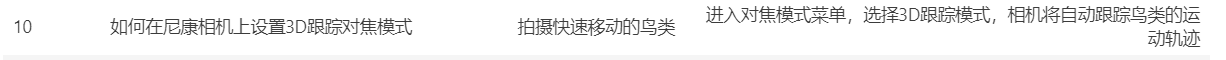

## 训练前效果：
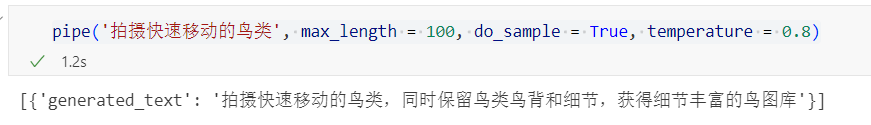

## 训练后效果
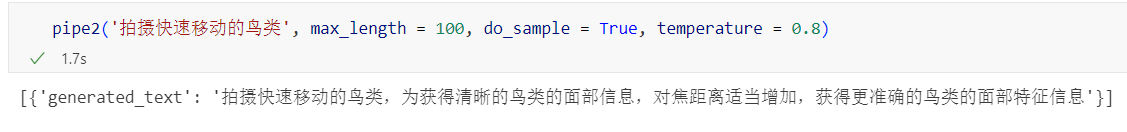